In [24]:
import random
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from termcolor import colored, cprint
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import torch.nn as nn

In [49]:
# Hyperparameters
opts = {}

# Data settings
opts['num_train_samples']=1000
opts['num_test_samples']=1000
opts['batch_size']=20
opts['num_categories']=3
opts['category_gap']=10
opts['num_gaussians']=2 # per x
opts['gauss_weights']=None
opts['gauss_gap']=20 # between gaussians

# Model and learning settings
opts['hidden_layer_size']=100
opts['learning_rate']=1e-4
opts['epochs']=3000

# Get data

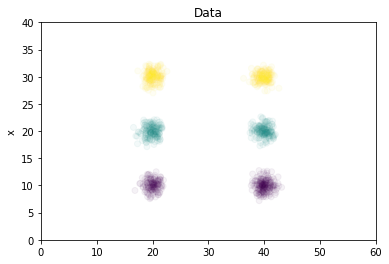

In [26]:
def conditional_gaussian_mixture(num_x, num_content_modes, num_style_modes, x_gap, gauss_gap, num_samples, batch_size, weights=None):    
    data = []  # Each sample will be (x, [y, y', ...])
    
    total_num_batches = int(num_samples/batch_size)
    for x_i in range(1,num_x+1): 
        # Content gaussians will determine one dimension of y
        content_gaussians = []
        start_loc = (x_i)*x_gap + (num_content_modes-1)*gauss_gap
        for gaussian_i in range(num_content_modes):
            gauss = norm(loc=start_loc+(gaussian_i)*gauss_gap)
            content_gaussians.append(gauss)
            
        # Style gaussians will determine a different dimension of y
        style_gaussians = []
        start_loc = gauss_gap # x_start_loc = (x_i+1)*x_gap + (num_gaussians-1)*gauss_gap
        for gaussian_i in range(num_style_modes):
            gauss = norm(loc=start_loc+(gaussian_i)*gauss_gap)
            style_gaussians.append(gauss)

        # Sampling
        num_batches = int(total_num_batches/num_x)
        for batch_i in range(num_batches):
            x = [x_i]
            Y = []
            for sample_i in range(batch_size):
                style_gauss = np.random.choice(style_gaussians, p=weights)
                content_gauss = np.random.choice(content_gaussians, p=weights)
                Y.append([style_gauss.rvs(size=1)[0], content_gauss.rvs(size=1)[0]])
            data.append((x, Y))    
    return data

train_data = conditional_gaussian_mixture(opts['num_categories'], 1, opts['num_gaussians'], opts['category_gap'], opts['gauss_gap'], opts['num_train_samples'], opts['batch_size'])
test_data = conditional_gaussian_mixture(opts['num_categories'], 1, opts['num_gaussians'], opts['category_gap'], opts['gauss_gap'], opts['num_test_samples'], opts['batch_size'])

# Plot Gaussians
fig, ax = plt.subplots()
plt.title('Data')
plt.ylabel('x')
plt.axis([0, (opts['num_gaussians']+1)*opts['gauss_gap'], 0, (opts['num_categories']+1)*opts['category_gap']])
data_categories = []
x_data = []
y_data = []
for [inputs,targets] in train_data:
    for data_point in targets:
        data_categories.append(inputs[0])
        x_data.append(data_point[0])
        y_data.append(data_point[1])
# colors = ['red', 'yellow', 'green','blue','cyan','magenta','black']
# key = {x:colors[x] for x in range(opts['num_x'])}
# p = ax.scatter(x=all_x, y=all_y, c=categories, alpha=.01)
p = plt.scatter(x=x_data, y=y_data, c=data_categories, alpha=.05)


In [27]:
# def conditional_gaussian_mixture(num_x, num_gaussians, x_gap, gauss_gap, num_samples, batch_size, weights=None):    
#     data = []  # Each sample will be (x, [y, y', ...])
#     total_num_batches = int(num_samples/batch_size)
#     for x_i in range(num_x): 
#         # Creating gaussians
#         gaussians = []
#         x_start_loc = (x_i+1)*x_gap + (num_gaussians-1)*gauss_gap
#         for gaussian_i in range(num_gaussians):
#             gauss = norm(loc=x_start_loc+(gaussian_i+1)*gap)
#             gaussians.append(gauss)
#         print(gaussians)

# #         # Sampling
# #         x_num_batches = int(total_num_batches/num_x)
# #         for batch_i in range(x_num_batches):
# #             x = [x_i]
# #             Y = []
# #             for sample_i in range(batch_size):
# #                 gauss = np.random.choice(gaussians, p=weights)
# #                 Y.append(gauss.rvs(size=1)[0])
# #             data.append((x, Y))    
#     return gaussians, data

# gaussians, train_data = conditional_gaussian_mixture(opts['num_x'], opts['num_gaussians'], opts['x_gap'], opts['gauss_gap'], opts['num_train_samples'], opts['batch_size'])
# _, test_data = conditional_gaussian_mixture(opts['num_x'], opts['num_gaussians'], opts['x_gap'], opts['gauss_gap'], opts['num_test_samples'], opts['batch_size'])

# # Plot Gaussians
# fig, ax = plt.subplots()
# plt.title('Data Histogram')
# plt.axis([0, (len(gaussians)+1)*opts['gap'],0,1])
# plt.ylabel('%')
# x = np.arange(0, (len(gaussians)+1)*opts['gap'], 1)
# for gauss in gaussians:
#     ax.plot(x, gauss.pdf(x))
# # Plot data
# sample_Y = [y for sample in train_data for y in sample[1]]
# h = ax.hist(sample_Y, density=True)

# Model and losses

In [53]:
# Define simple neural net
def get_new_model():
    model = torch.nn.Sequential(
    torch.nn.Linear(1, opts['hidden_layer_size']),
    torch.nn.ReLU(),
    torch.nn.Linear(opts['hidden_layer_size'], 2),
    )
    return model

In [54]:
# Write and loss,or loss
class StandardLossDefiner(torch.nn.Module):
    def __init__(self):
        super(StandardLossDefiner, self).__init__()
        self.loss_function = nn.MSELoss(reduction='elementwise_mean')

    def forward(self, pred, targets):
        return self.loss_function(pred.expand_as(targets),targets) # avg in log space (all y)

    
class SumLossDefiner(torch.nn.Module):
    def __init__(self):
        super(SumLossDefiner, self).__init__()
        self.loss_function = nn.MSELoss(reduction='none')

    def forward(self, pred, targets):
        losses = self.loss_function(pred.expand_as(targets),targets)
        losses = torch.sum(losses, dim=1) # in log space (all dims)
        Y_loss = torch.logsumexp(losses, dim=0)/opts['batch_size'] # avg in non log-space (any y in Y)
        return Y_loss
    
class MaxLossDefiner(torch.nn.Module):
    def __init__(self):
        super(MaxLossDefiner, self).__init__()
        self.loss_function = nn.MSELoss(reduction='none')

    def forward(self, pred, targets):
        losses = self.loss_function(pred.expand_as(targets),targets)
        losses = torch.sum(losses, dim=1) # in log space (all dims)
        Y_loss = torch.min(losses, dim=0)[0] # min (any target)
        return Y_loss
    
standard_criterion = StandardLossDefiner()
sum_criterion = SumLossDefiner()
max_criterion = MaxLossDefiner()

# Train and test

In [55]:
def prep(li):
    return torch.FloatTensor(li) # e.g. x=[1.]

print('sample in:',prep(train_data[0][0]))
print('sample out:',prep(train_data[0][1]))

sample in: tensor([1.])
sample out: tensor([[21.5222, 10.4705],
        [40.4559, 12.2997],
        [38.1701,  9.8949],
        [41.0059, 10.8264],
        [20.1266, 10.0279],
        [39.3183, 12.1072],
        [40.7956,  9.9719],
        [40.1129, 10.4517],
        [19.6507,  8.9534],
        [39.0684,  9.9113],
        [21.0780, 10.1186],
        [39.1758,  9.9312],
        [17.7018, 10.3417],
        [41.7192, 11.1805],
        [20.1114,  8.6288],
        [16.8480,  9.0724],
        [21.0199, 10.2563],
        [39.9938,  9.9443],
        [39.9675,  9.9773],
        [40.8972,  8.6950]])


In [56]:
def train_and_test(criterion):
    optimizer = torch.optim.Adam(model.parameters(), lr=opts['learning_rate'])
    for epoch in range(opts['epochs']):
        # Train
        epoch_loss=0.0
        for (inputs,targets) in train_data:
            # Forward pass: compute predicted y
            prediction = model(prep(inputs))
            loss = criterion(prediction, prep(targets))
            # Backward pass: compute gradient of the loss with respect to model
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            # Stats
            epoch_loss += loss.item()
        
        if epoch%(opts['epochs']/10) == 0:
            # Predict
            categories = []
            x_predictions = []
            y_predictions = []
            for (inputs,targets) in test_data:
                categories.append(inputs[0])
                (x_prediction, y_prediction) = model(prep(inputs))
                x_predictions.append(x_prediction.item())
                y_predictions.append(y_prediction.item())

            
            # Report
            print('Epoch %d loss:%.3f' % (epoch, epoch_loss))
            fig, ax = plt.subplots()
#             plt.title('Epoch %d predictions' % (epoch))
            plt.axis([0, (opts['num_gaussians']+1)*opts['gauss_gap'], 0, (opts['num_categories']+1)*opts['category_gap']])
            p = plt.scatter(x=x_data, y=y_data, c=data_categories, alpha=.02)
            p = plt.scatter(x=x_predictions, y=y_predictions, c=categories, edgecolors='black')
            
    return

In [57]:
model = get_new_model()

Epoch 0 loss:35374.691
Epoch 300 loss:35.132
Epoch 600 loss:10.130
Epoch 900 loss:10.083
Epoch 1200 loss:10.042
Epoch 1500 loss:9.996
Epoch 1800 loss:9.954
Epoch 2100 loss:9.909
Epoch 2400 loss:9.814
Epoch 2700 loss:9.727


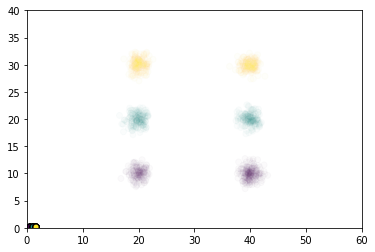

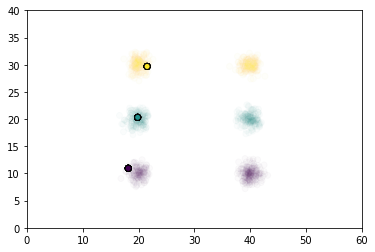

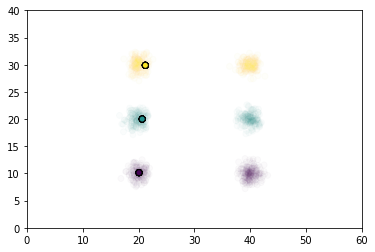

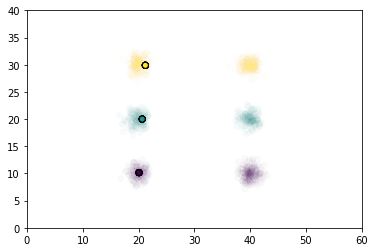

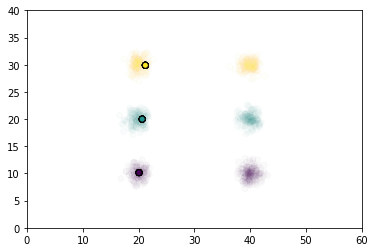

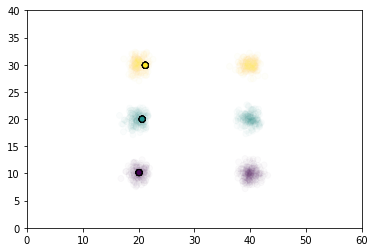

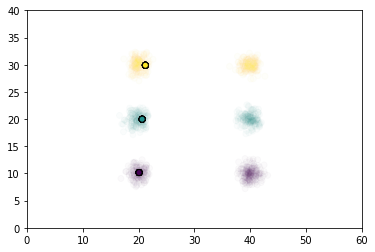

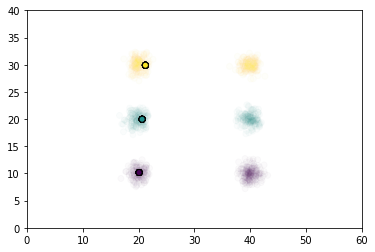

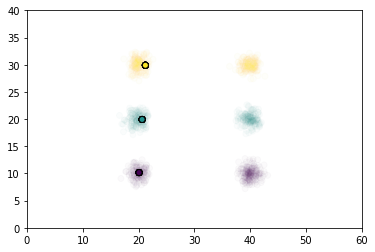

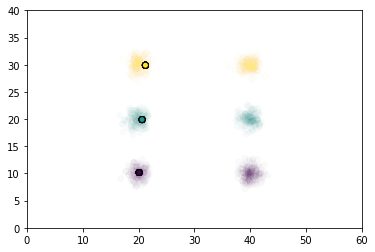

In [58]:
train_and_test(max_criterion)

In [59]:
model = get_new_model()

Epoch 0 loss:34117.971
Epoch 300 loss:2688.335
Epoch 600 loss:2423.880
Epoch 900 loss:2422.627
Epoch 1200 loss:2422.396
Epoch 1500 loss:2422.227
Epoch 1800 loss:2422.060
Epoch 2100 loss:2421.904
Epoch 2400 loss:2421.772
Epoch 2700 loss:2421.671


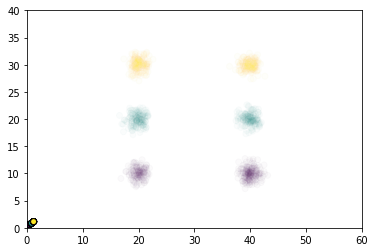

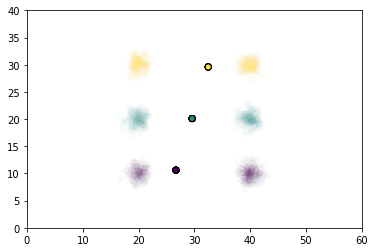

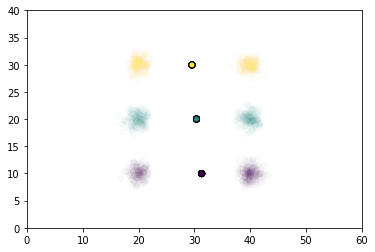

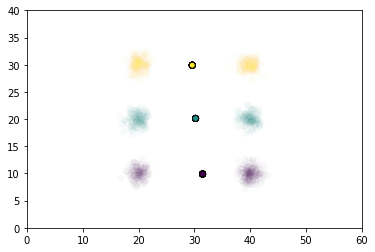

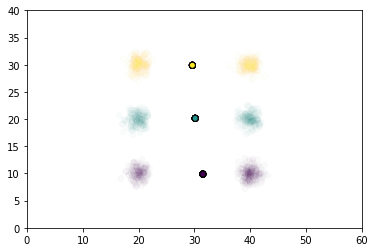

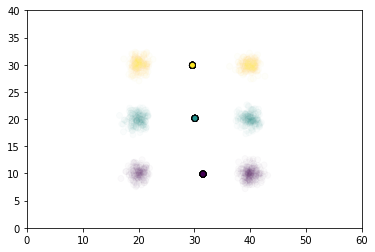

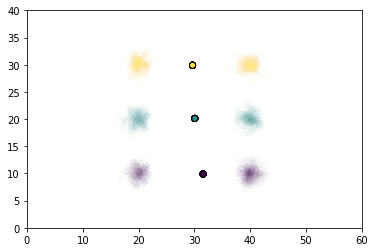

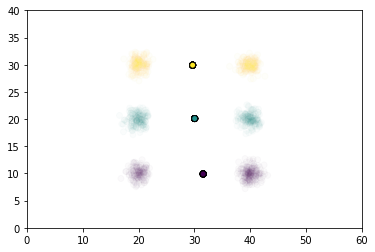

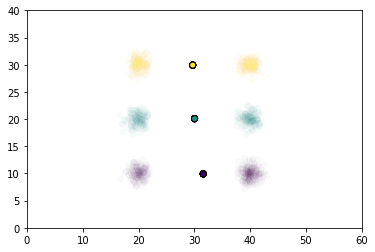

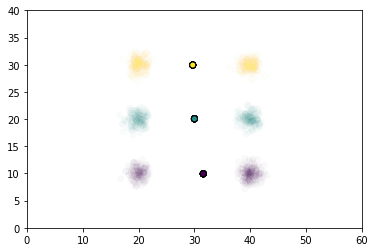

In [60]:
train_and_test(standard_criterion)

In [61]:
model = get_new_model()

Epoch 0 loss:5322.192
Epoch 300 loss:451.380
Epoch 600 loss:336.741
Epoch 900 loss:336.729
Epoch 1200 loss:336.725
Epoch 1500 loss:336.721
Epoch 1800 loss:336.717
Epoch 2100 loss:336.713
Epoch 2400 loss:336.708
Epoch 2700 loss:336.704


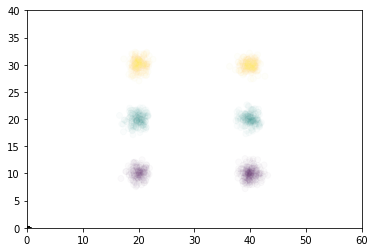

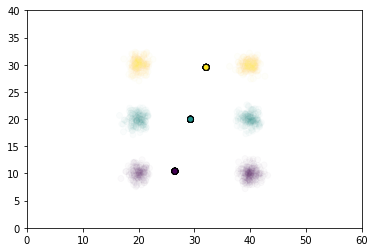

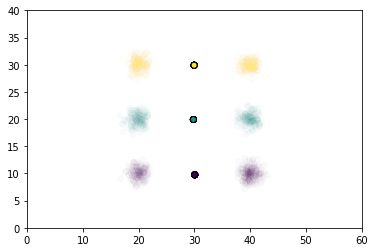

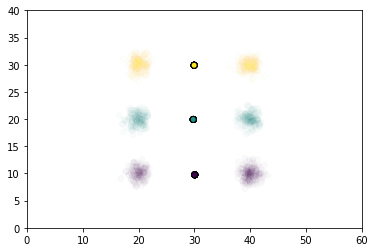

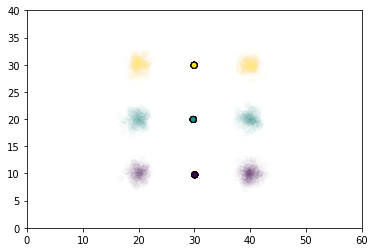

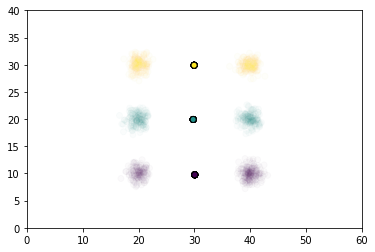

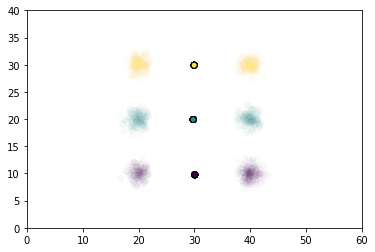

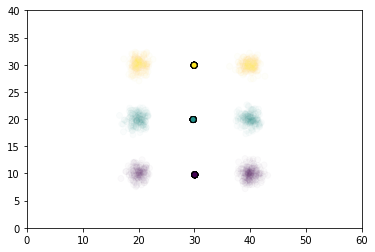

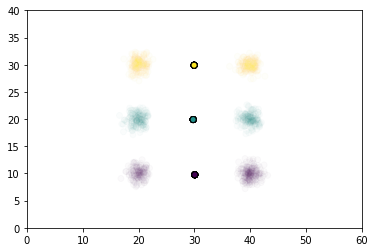

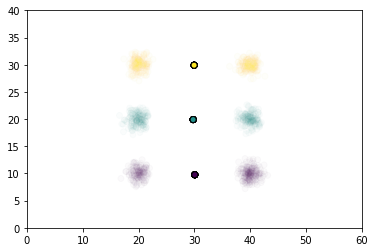

In [62]:
train_and_test(sum_criterion)